As the name suggests, this augmentation technique inspired from Resnet architecture. As in Resnet, we try to work only on residual data or the data which the model did not learned. This augmentation specifically focussed on improving the edge detection of the model. So, we will derive the edge detection map using a pretrained or base model. And we will analyze the range of the values and derive a threshold. Next, the regions which are exceeding the threshold represents that the model is confident that there is an edge there. So, it is waste of resources on training on those regions. So, we will fill that particular region or pixels with gray. So, after filling the regions completely, now we are only having the part of image which the model is able to detect properly or the residual. Now, if we train the model on these images, the model will learn to detect edges which it did not before. And as we are modifying values at pixel level, the kernels are directly regularized and also, this technique also provide use the similar impact of noise injection as we are introducing artifacts into the image.

And also, during retraining of the model, we will freeze all layers except the first layer. Due to this, there will be no vanishing gradient problem as well as the changes in the top layers have direct impact on the output of the model. As we only need to train single layer, we have less training parameters due to that, we can improve the edge detection much faster.

In [1]:
# Importing the required libraries
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import pathlib as pl
from tensorflow.keras.models import load_model
from skimage.filters import laplace
from PIL import Image, ImageFilter
from tensorflow import keras
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
from tensorflow.keras.models import Model
import copy

In [7]:
# Loading the image
image = cv.imread(r"D:\Samsung Prism\Datasets\Cat and Dog\Training\Cat\cat.100.jpg")
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image, (300, 300))

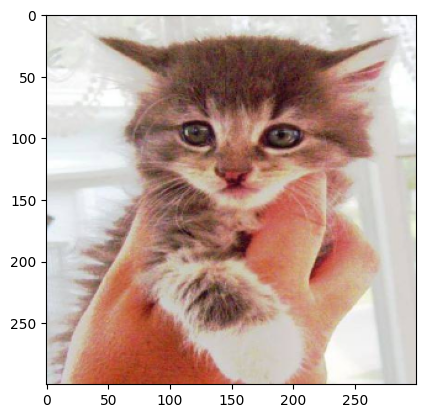

In [8]:
plt.imshow(image)

In [9]:
# Loading a base model
model = load_model(r"Sequential Model/Base Model.h5")

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 298, 298, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 298, 298, 32)     128       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 149, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      1

In [6]:
# Getting the inputs and outputs of each layer
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])

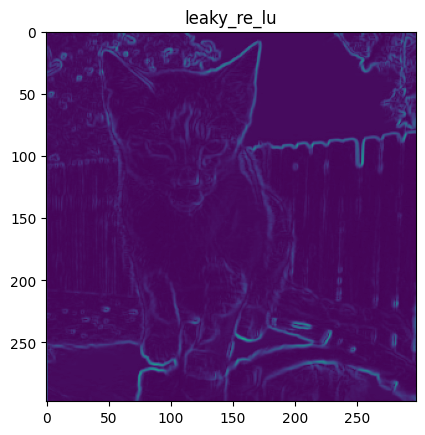

<Figure size 640x480 with 0 Axes>

In [7]:
# Getting the feature map of the edges detected
features = extractor(np.expand_dims(image/255.0, 0))
for j in range(1, 2):
    l_features = features[j].numpy()[0]
    dim = len(l_features[..., 0])
    final_img = np.zeros((dim, dim))
    for i in range(len(l_features[0][0])):
        final_img = final_img + l_features[..., i]
    m = np.max(final_img)
    final_img = final_img/m
    img1 = final_img
    plt.imshow(final_img)
    plt.title(model.layers[j].name)
    plt.figure()

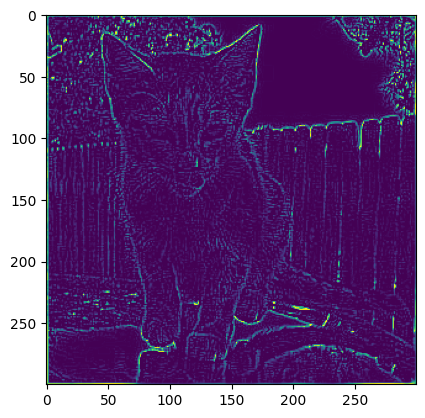

In [8]:
# Finding the edges using Laplacian filter to show how much our current model is lagging in terms of edge detection
image_t = Image.fromarray(image)
image_t = image_t.convert("L")
image_t = image_t.filter(ImageFilter.FIND_EDGES)
image_t = np.asarray(image_t)
plt.imshow(image_t)

In [9]:
# Finding an ideal threshold using the maximum and minimum of the pixel values.
# Here, if the threshold is the 30% of the whole range of values
maxi = np.max(final_img)
mini = np.min(final_img)
threshold = (maxi-mini)*0.3

In [10]:
# Using the threshold, we are finding the areas of interest (regions of the feature map where the model is detecting the edges 
# with value higer than the threshold)
areas_of_interest = np.where(final_img > threshold)

# Filling those regions with gray color
modified = copy.deepcopy(image)
for i in range(len(areas_of_interest[0])):
    y = areas_of_interest[0][i]
    x = areas_of_interest[1][i]
    x += 1
    y += 1
    new_x1 = x-1
    new_x2 = x+1
    new_y1 = y-1
    new_y2 = y+1
    visited_points = []
    for i in range(new_x1, new_x2):
        for j in range(new_y1, new_y2):
            if (i > 0 and j > 0) and (i < modified.shape[0] and j < modified.shape[1]) :
                modified[j][i] = 127
                visited_points.append((i, j))

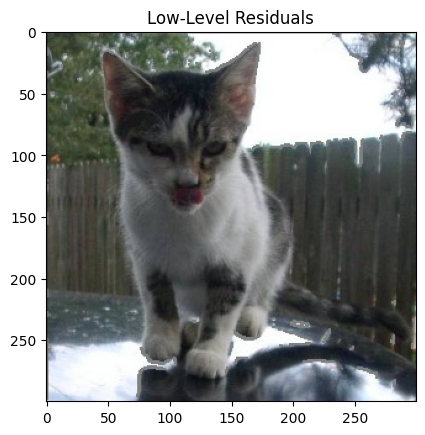

In [11]:
plt.title("Low-Level Residuals")
plt.imshow(modified)

In [12]:
# To show the improvement in the edge detection, we have imported a base model as well as model which is trained on the LLR data.
# Note: The second model is trained with all layers frozen except the top layers.
model_without_llr = load_model(r"Sequential Model/Sq flip + negative + as (gray).h5")
model_with_llr = load_model(r"Sequential Model/Sq flip + negative + as (gray) + llr.h5")

In [13]:
# Getting the inputs and output weights of each layer
extractor1 = keras.Model(inputs=model_without_llr.inputs, outputs=[layer.output for layer in model_without_llr.layers])
extractor2 = keras.Model(inputs=model_with_llr.inputs, outputs=[layer.output for layer in model_with_llr.layers])

In [14]:
# Finding the feature map of the edges detected of the both models
features = extractor1(np.expand_dims(image/255.0, 0))
for j in range(1, 2):
    l_features = features[j].numpy()[0]
    dim = len(l_features[..., 0])
    final_img = np.zeros((dim, dim))
    for i in range(len(l_features[0][0])):
        final_img = final_img + l_features[..., i]
    m = np.max(final_img)
    final_img = final_img/m
    img1 = final_img
    
features = extractor2(np.expand_dims(image/255.0, 0))
for j in range(1, 2):
    l_features = features[j].numpy()[0]
    dim = len(l_features[..., 0])
    final_img = np.zeros((dim, dim))
    for i in range(len(l_features[0][0])):
        final_img = final_img + l_features[..., i]
    m = np.max(final_img)
    final_img = final_img/m
    img2 = final_img

In [15]:
# Normalizing the range of the feature map between 0 and 1
new_img1 = (img1 - np.min(img1))/(np.max(img1) - np.min(img1))
new_img2 = (img2 - np.min(img2))/(np.max(img2) - np.min(img2))

# Expanding the range between 0 and 255
new_img1 *= 255
new_img2 *= 255
new_img1 = np.array(new_img1, dtype="uint8")
new_img2 = np.array(new_img2, dtype="uint8")

# Finding the structural similarity index between the both feature maps
score, dif = compare_ssim(new_img1, new_img2, full=True)

In [16]:
print(f"Structure Similarity Index of the both edge detections: {score}")

Structure Similarity Index of the both edge detections: 0.7894418176165485


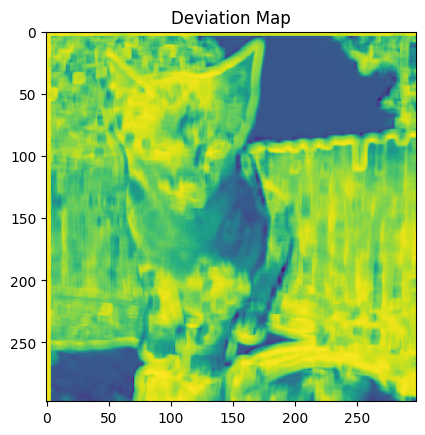

In [17]:
# The yellow regions are the regions where the edge detection has improved.
plt.title("Deviation Map")
plt.imshow(dif)

In [10]:
# Based on the above image, we have see how much deviation between the base model and the model trained using LLR. So, this is 
# one of the efficient augmentation technique which is inspired from the Resnet architecture.
# As we are manipulating at pixel level, this technique can used as Kernel Regularizer. 
# As we are injecting artifacts into the image, this technique also provides effect of noise injection augmentation.

In [12]:
# For batch execution, pass the path of input file and output file

input_file_path = r"D:\Samsung Prism\Datasets\Cat and Dog\Training\Dog"
output_file_path = r"D:\Samsung Prism\Datasets\Cat and Dog\Low-level Residual 2\Dog"
pathlib_file= pl.Path(input_file_path)

def low_level_regularizer(image, areas_of_interest):
    modified = copy.deepcopy(image)
    for i in range(len(areas_of_interest[0])):
        y = areas_of_interest[0][i]
        x = areas_of_interest[1][i]
        x += 1
        y += 1
        new_x1 = x-1
        new_x2 = x+1
        new_y1 = y-1
        new_y2 = y+1
        visited_points = []
        for i in range(new_x1, new_x2):
            for j in range(new_y1, new_y2):
                if (i > 0 and j > 0) and (i < modified.shape[0] and j < modified.shape[1]) :
                    modified[j][i] = 127
                    visited_points.append((i, j))
    return modified

In [13]:
# Using the activation map of each image, applying the Activation Suppression augmentation

all_img_path = list(pathlib_file.glob("*"))
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
n_suppressions = 2
counter = 0
for i in all_img_path:
    img = cv.imread(str(i))
    img = cv.resize(img, (300, 300))
    features = extractor(np.expand_dims(img/255.0, 0))
    for j in range(1, 2):
        l_features = features[j].numpy()[0]
        dim = len(l_features[..., 0])
        final_img = np.zeros((dim, dim))
        for i in range(len(l_features[0][0])):
            final_img = final_img + l_features[..., i]
        m = np.max(final_img)
        final_img = final_img/m
    activation = final_img
    maxi = np.max(final_img)
    mini = np.min(final_img)
    threshold = (maxi-mini)*0.3
    areas_of_interest = np.where(final_img > threshold)
    modified = low_level_regularizer(img, areas_of_interest)

    cv.imwrite(output_file_path + "\\" + "aug_llr_"+str(counter) + ".jpg", modified)
    counter += 1